In [6]:
import numpy as np
import pandas as pd
import cv2
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
from glob import glob
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

In [ ]:
!pip install sentencepiece
!pip install PyICU

In [8]:
from keras.utils import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import add
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from keras.models import Sequential, Model


# Loading Image from folder 

In [ ]:
images_path = '/content/drive/MyDrive/dataset/stanford_img/content/stanford_images/'
images = glob(images_path+'*.jpg')
print("Total images in dataset:",len(images))
for i in range(5):
    plt.figure()
    img = cv2.imread(images[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

# Preprocessing Images

- Assuming you have loaded the image and pre-trained model. The models we are going to test are Restnet50, VGG16,resnet 152, and Inception V3
- Preprocess the image using the pre-trained model to extract features
- Save the extracted image features to a pickle file


# Restnet50

In [ ]:
# Load Pre-Train model (No need to run this cell  )
incept_model = ResNet50(include_top=True)
last = incept_model.layers[-2].output
CNNmodel = Model(inputs = incept_model.input,outputs = last)

In [ ]:

# Extracting the feature from pre trained model ( no need to run this cell)

images_features = {}
count = 0
print("Converting images to features using CNN model")
for i in images:
   img = cv2.imread(i)
   img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
   img = cv2.resize(img, (224,224))
   img = img.reshape(1,224,224,3)
   pred = CNNmodel.predict(img).reshape(2048,)
   img_name = i.split('/')[-1]
   images_features[img_name] = pred
   count += 1
   if count % 500 == 0:
       print("Completed for "+str(count)+" images")
print("length of image features:",len(images_features))
list(images_features.items())[:5]

In [9]:

# Loaded rom the file 
import pickle
images_features = {}
pickle_file_path = "/content/drive/MyDrive/dataset/stanford_img/pickle/restnet50_images_features.pkl"

with open(pickle_file_path, "rb") as f:
  images_features = pickle.load(f)
len(images_features)

19551

# VGG16

In [ ]:
# Load pre-trained VGG16 model (no need to run this )
vgg_model = VGG16(include_top=True, weights='imagenet')
vgg_model.layers.pop()  # Remove the classification layer
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-1].output)

In [ ]:

# Extracting the feature from pre trained model ( no need to run this cell)
images_features = {}
count = 0
print("Converting images to features using CNN model")
for i in images:
   img = cv2.imread(i)
   img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
   img = cv2.resize(img, (224,224))
   img = img.reshape(1,224,224,3)
   pred = vgg_model.predict(img).reshape(1000,)
   img_name = i.split('/')[-1]
   images_features[img_name] = pred
   count += 1
   if count % 500 == 0:
       print("Completed for "+str(count)+" images")
print("length of image features:",len(images_features))
list(images_features.items())[:5]

In [ ]:
# Loaded from file
pickle_file_path = '/content/drive/MyDrive/dataset/stanford_img/pickle/inception_features.pkl'
with open(pickle_file_path, "rb") as f:
  images_features = pickle.load(f)
len(images_features)

# Preprocessing Captions and Creating Vocabulary

In [10]:
caption_path = '/content/drive/MyDrive/dataset/stanford_img/stanford dataset_nepali.csv'

with open(caption_path) as csvfile:
    captions=csv.reader(csvfile, delimiter=',', quotechar='"')
    captions_dict_train,captions_dict_test,captions_dict_val= {},{},{}
    for i in captions:
        try:
            img_name = i[0]  + ".jpg"
            caption = i[1]
            train_input=i[2]
            test_input=i[3]
            val_input=i[5]
            if img_name in images_features.keys():
                if train_input =='True':
                    captions_dict_train[img_name] = caption
                elif test_input =='True':
                    captions_dict_test[img_name] = caption
                elif val_input =='True':
                    captions_dict_val[img_name] = caption
        except:
            pass

print("size of train, test and validation dataset:" ,len(captions_dict_train),len(captions_dict_test),len(captions_dict_val))

size of train, test and validation dataset: 14575 2489 2487


# Visualize The Captions And Model Class

In [ ]:
data = pd.read_csv("/kaggle/input/stanford-image-paragraph-captioning-dataset/stanford_df_rectified.csv")

In [ ]:
class Visualize:
    def __init__(self,data):
        self.data=data
        self.train_dataset = data[data['train']]
        self.test_dataset = data[data['test']]
        self.val_dataset = data[data['val']]

        self.train_size = self.train_dataset.shape[0]
        self.test_size = self.test_dataset.shape[0]
        self.val_size = self.val_dataset.shape[0]
    
    def caption_pie(self,colors=['#ff3333', '#33cc33', '#3333ff']):
        sizes = [self.train_size, self.test_size, self.val_size]
        labels = ['Train', 'Test', 'Validation']
        plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90,
                wedgeprops={'linewidth': 1, 'edgecolor': 'black'})

        plt.axis('equal')
        plt.title('Dataset Split Sizes')
        plt.show()
        print("size of train, test and validation dataset:" ,sizes)
        return self
    
    def caption_wordcloud(self,width=800,height=400,color="white"):
        wordcloud = WordCloud(width=width, height=height, background_color=color).generate(' '.join(self.data['Paragraph']))
        plt.figure(figsize=(10, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('\n\nWord Cloud for Captions\n')
        plt.show()

        
    def _readImage(self,path,img_size):
        img = load_img(path=path,color_mode='rgb',target_size=(img_size,img_size),interpolation='bilinear')
        img = img_to_array(img)
        img = img/255.
        return img
    
    def display_images_with_caption(self,sample=5,img_size=299):
        data=self.data.sample(sample)
        temp_df = data.reset_index(drop=True)
        plt.figure(figsize = (20 , 20))
        n = 0
        for i in range(sample):
            n+=1
            plt.subplot(5 , 5, n)
            plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
            image = self._readImage(f"/kaggle/input/stanford-image-paragraph-captioning-dataset/stanford_img/content/stanford_images/{temp_df.Image_name[i]}.jpg",img_size)
            plt.imshow(image)
            plt.title("\n".join(wrap(temp_df.Paragraph[i], 20)))
            plt.axis("off")
            
    def model(self,history):
        plt.figure(figsize=(20,8))
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
        

In [ ]:
visualize=Visualize(data)

# Embedding


In [ ]:
import os
import sys
sys.path.append('..')

import gensim
from gensim.models.keyedvectors import KeyedVectors

class Embeddings:
    """This class helps to load embedding in keyedvector format."""

    def __init__(self):
        pass

    def load_large_vector(self):
        """Download and load embedding. #This is private embedding I will update link later

        Returns:
            [keyedVectors] -- [Custom Nepali word Embedding]
        """
        # download = Download()
        # download.download_file_from_google_drive('1ik38vahOmzhiU2DBi78VOqDt7YFPsk5w', 'word_vector.sg')
        # word_vector = KeyedVectors.load_word2vec_format('word_vector.sg', binary=False)
        # os.remove("word_vector.sg")

        # return word_vector
        # download = Download()
        # download.download_file_from_google_drive('1ik38vahOmzhiU2DBi78VOqDt7YFPsk5w', 'word_vector.sg')

        # Check if the downloaded file exists
        word_vector = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/dataset/local_dataset/nepali_embeddings_word2vec.txt', binary=False)
        # os.remove("word_vector.sg")  # Remove the temporary file after loading

        return word_vector

    def load_vector(self):
        """Returns a large Nepali word embedding. Creator: https://github.com/rabindralamsal/Word2Vec-Embeddings-for-Nepali-Language

        Returns:
            [keyedVectors] -- [Custom Nepali word Embedding]
        """
        download = Download()
        download.download_file_from_google_drive('1KnAZ2Eeqwz3S9VrAuzTLWysAaRB6Ch7e', 'nepali_embeddings_word2vec.txt')
        word_vector = KeyedVectors.load('nepali_embeddings_word2vec.txt')
        os.remove("nepali_embeddings_word2vec.txt")

        return word_vector

    def __str__(self):
        return "Required to load different emebeddings"

In [ ]:
word_vec = Embeddings().load_large_vector()

In [ ]:
# word_vec.most_similar("")
word_vec.most_similar("एउटा")

# Preprossing Caption and creating vocab

In [ ]:


import os
import sys
import tensorflow as tf
import sentencepiece as spm

import ast
import string

import snowballstemmer

sys.path.append('..')

path='drive/MyDrive/dataset/local_dataset'
class CaptionPreProcessing:
  def __init__(self):
    self.this_dir=os.path.dirname(os.path.abspath(__file__)) if '__file__' in locals() else os.getcwd()
    self.stemmer = snowballstemmer.NepaliStemmer()

  def sentence_tokenize(self, text):
    """This function tokenize the sentences

    Arguments:
        text {string} -- Sentences you want to tokenize

    Returns:
        sentence {list} -- tokenized sentence in list
    """
    sentences = text.strip().split(u"।")
    sentences = [sentence.translate(str.maketrans('', '', string.punctuation)) for sentence in sentences]
    return sentences

  def word_tokenize(self, sentence, new_punctuation=[]):
        """This function tokenize with respect to word

        Arguments:
            sentence {string} -- sentence you want to tokenize
            new_punctuation {list} -- more punctutaion for tokenizing  default ['।',',',';','?','!','—','-']

        Returns:
            list -- tokenized words
        """
        punctuations = ['।', ',', ';', '?', '!', '—', '-', '.']
        if new_punctuation:
            punctuations = set(punctuations + new_punctuation)

        for punct in punctuations:
            sentence = ' '.join(sentence.split(punct))

        return sentence.split()

  def remove_stopwords(self,text):
      """This function remove stopwords from text

      Arguments:
      sentence {string} -- sentence you want to remove stopwords
      Returns:
          list -- token words
      """
      f = open(f'/content/{path}/stopword1.txt','r')
      stopwords = f.read()
      stopwords = ast.literal_eval(stopwords)
      word_without_stopword=[]
      for word in text:
          if word not in stopwords:
              word_without_stopword.append(word)

      return word_without_stopword

  def stem(self, text):
      """Generates the stem words for input text.

      Args:
          text (Union(List, str)): Text to be stemmed or lemmatized.

      Returns:
          Union(List, str): stemmed text.
      """
      if isinstance(text, str):
          return self.stemmer.stemWords(text.split())

      return self.stemmer.stemWords(text)


In [ ]:


caption_preprocessor = CaptionPreProcessing()
preProcessedData={}
count=0
# Example of how to process captionslist(output_captions.items()
for image_filename, caption_text in captions_dict_train.items():
    # Tokenize and preprocess captions
    # sentences = caption_preprocessor.sentence_tokenize(caption_text)
    tokenized_words = [caption_preprocessor.word_tokenize(caption_text)]
    without_stopwords = [caption_preprocessor.remove_stopwords(words) for words in tokenized_words]
    stemmed_words = [caption_preprocessor.stem(words) for words in tokenized_words]
    preProcessedData[image_filename]=" ".join(stemmed_words[0])
    count+=1
    print("Done ", count)



Done  1
Done  2
Done  3


# Getting From The Saved Corpus File

Reading the saved preprocessed caption from pickle file

In [13]:
preProcessedData = {}
caption_preprocessed_file_path = "/content/drive/MyDrive/dataset/stanford_img/pickle/caption_preprocessed_2.pkl"

with open(caption_preprocessed_file_path, "rb") as f:
  preProcessedData = pickle.load(f)
len(preProcessedData)

14575

In [ ]:
preProcessedData

# Creating Word Dict

Creating word_dict set and saving to pickle file

In [17]:
def preprocessed(txt):
    modified = txt.replace("'","")
    modified = 'startofseq ' + modified + ' endofseq'
    return modified

count_words = {}
captions_dict_train=preProcessedData
print("Captions before preprocessing\n ",captions_dict_train.items())

for k,v in captions_dict_train.items():
    captions_dict_train[k]=preprocessed(v)

print(captions_dict_train)
# creating count_words dict with word and frequency
for k,v in captions_dict_train.items():
    for word in v.split():
        if word not in count_words:
            count_words[word] = 1
        else:
            count_words[word] += 1
print("captions_dict_train",captions_dict_train)
print("count_words ",count_words)
#creating words_dict as vocabulary where only words occuring more than threshold is considered
THRESH = 5
count = 1
words_dict = {}
for k,v in count_words.items():
    if count_words[k] > THRESH:
        words_dict[k] = count
        count += 1


print("words_dict",words_dict)
#captions_dict converting words into numbers from words_dict
for k, v in captions_dict_train.items():
    encoded = []
    for word in v.split():
        if word in words_dict.keys():
            encoded.append(words_dict[word])

    captions_dict_train[k] = encoded

print("Captions after preprocessing\n ",list(captions_dict_train.items())[:5])



# TO

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Captions after preprocessing
  [('2317429.jpg', [1, 2, 3, 4, 5, 6, 7, 2, 4, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 6, 18, 2, 4, 19, 2, 20, 2, 4, 21, 4, 22, 23, 24, 5, 25, 26]), ('2365091.jpg', [1, 27, 28, 2, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 42, 45, 46, 16, 28, 19, 28, 47, 48, 49, 2, 29, 50, 51, 26]), ('2383120.jpg', [1, 52, 52, 53, 54, 52, 55, 2, 53, 56, 57, 58, 26]), ('2333990.jpg', [1, 59, 60, 4, 61, 62, 63, 64, 65, 66, 62, 63, 67, 28, 68, 69, 54, 60, 70, 2, 5, 71, 26]), ('2338364.jpg', [1, 23, 2, 72, 2, 73, 74, 72, 75, 76, 73, 77, 23, 78, 23, 47, 73, 19, 2, 79, 80, 26])]


In [ ]:
captions_dict_train

In [ ]:
words_dict

Original Code


In [19]:
# Retriving the saved word_dict from pickle file

import pickle

with open("/content/drive/MyDrive/dataset/stanford_img/pickle/words_dict.pkl", "wb") as f:
   pickle.dump(words_dict , f)


In [ ]:
captions_dict_train

# Merge Model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 134)]                0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 134, 134)             419152    ['input_2[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 2048)                 0         ['input_1[0][0]']             
                                                                                              

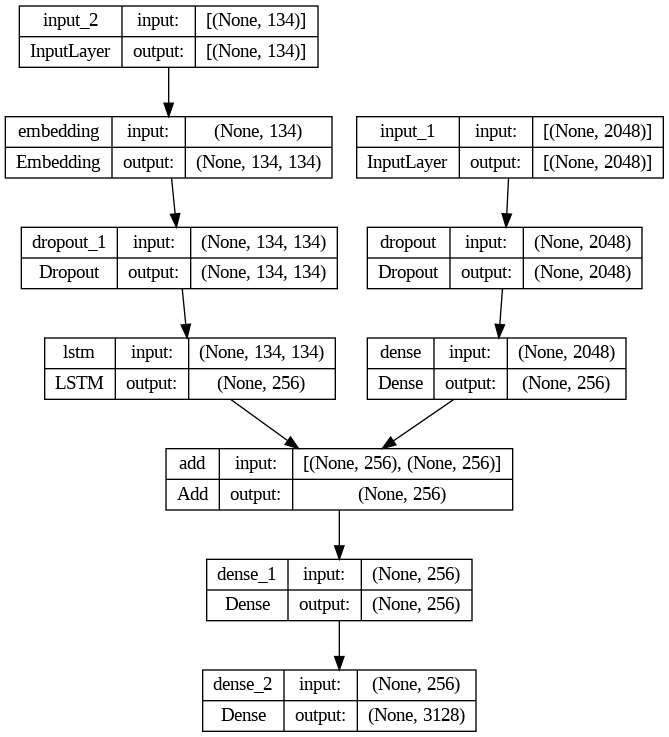

In [21]:

vocab_size = len(words_dict)+1
MAX_LEN = 0

for k, v in captions_dict_train.items():
    if len(v) > MAX_LEN:
        MAX_LEN = len(v)

# feature extractor model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# language sequence model
inputs2 = Input(shape=(MAX_LEN,))
se1 = Embedding(vocab_size, MAX_LEN, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# tie it together [image, seq] [word]
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
# summarize model
model.summary()
plot_model(model, show_shapes=True)


# Training RNN- Using Generator Function to create input

In [23]:
N=32 #BatchSize
VOCAB_SIZE = len(words_dict)+1

def progressive_generator(photo_dict, caption_dict, MAX_LEN,VOCAB_SIZE):
    while 1:
        for i in range(0,len(caption_dict),N):
            caption = dict(list(caption_dict.items())[0+i: N+i])
            X, y_in, y_out = create_sequences(photo_dict,caption,MAX_LEN, VOCAB_SIZE)
            yield [X, y_in], y_out


def create_sequences(photo, caption, MAX_LEN,VOCAB_SIZE):
    #n_samples = 0
    X,y_in,y_out = [],[],[]

    for k, v in caption.items():
        for i in range(1, len(v)):
            X.append(photo[k])

            in_seq= [v[:i]]
            out_seq = v[i]

            in_seq = pad_sequences(in_seq, maxlen=MAX_LEN, padding='post', truncating='post')[0]
            out_seq = to_categorical([out_seq], num_classes=VOCAB_SIZE)[0]

            y_in.append(in_seq)
            y_out.append(out_seq)

    return np.array(X), np.array(y_in), np.array(y_out)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import os

# Define the checkpoint filepath with a placeholder for the epoch number
checkpoint_filepath = '/content/drive/MyDrive/dataset/stanford_img/pickle/image_caption_model_{epoch:02d}.h5'

# Try loading the model from checkpoint
try:
    model = load_model(checkpoint_filepath)
    print("Loaded model from checkpoint.")

    # Get the last epoch from the checkpoint
    filename = os.path.basename(checkpoint_filepath)
    last_epoch = int((filename.split('_')[-1]).split(".")[0])
except:
    # Create a new model if checkpoint doesn't exist
    print("Creating a new model.")
    last_epoch = 0

# Define the callback to save the model after each epoch
checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    save_weights_only=False,  # Save the entire model
    save_best_only=False,
    monitor='loss',
    mode='min',
    verbose=1,
    save_freq='epoch',  # Save every epoch
    initial_epoch=last_epoch
)

# Calculate steps per epoch
steps = len(captions_dict_train) // N
print("Steps per epoch:", steps)

# Create and compile the model
generator = progressive_generator(images_features, captions_dict_train, MAX_LEN, VOCAB_SIZE)

# Fit the model with the generator and use the ModelCheckpoint callback
model.fit(generator, epochs=50, steps_per_epoch=steps, verbose=1, callbacks=[checkpoint])

# Save the final model
model.save('/content/drive/MyDrive/dataset/stanford_img/pickle/image_caption_model_newarch50_final.h5')


Creating a new model.
Steps per epoch: 455
Epoch 1/50
202/455 [============>.................] - ETA: 28:37 - loss: 5.2763 - accuracy: 0.1027

#  Prediction

In [ ]:
vocab_size = len(words_dict)+1
MAX_LEN = 0

for k, v in captions_dict_train.items():
    if len(v) > MAX_LEN:
        MAX_LEN = len(v)

inv_dict = {v:k for k, v in words_dict.items()}

In [ ]:
existing_image_features

In [ ]:
## For selected test images

#2373586.jpg 75 epoch
#2361833.jpg 75 epoch

#2394335.jpg 150 epoch
#2364210.jpg 150 epoch
#2402430.jpg 2395361.jpg 150 epoch
#2335374.jpg 2373374.jpg 150 epoch


model = tf.keras.models.load_model('/content/drive/MyDrive/dataset/stanford_img/pickle/image_caption_model_newarch50_checkpoint.h5')
img_name='2327483.jpg'
test_feature = existing_image_features[img_name]
test_img_path = '/content/drive/MyDrive/dataset/stanford_img/content/stanford_images/2327483.jpg'
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)


text_inp = ['startofseq']
count = 0
caption = ''
while count < MAX_LEN:
    count += 1
    encoded = []
    for i in text_inp:
        encoded.append(words_dict[i])
    encoded = [encoded]
    encoded = pad_sequences(encoded, padding='post', truncating='post', maxlen=MAX_LEN)
    data_list=[np.array(test_feature).reshape(1,-1), np.array(encoded).reshape(1,-1)]
    prediction = np.argmax(model.predict(data_list))
    sampled_word = inv_dict[prediction]
    caption = caption + ' ' + sampled_word

    if sampled_word == 'endofseq':
        break
    text_inp.append(sampled_word)

caption= caption.replace('endofseq','')
predicted= caption.split()
# actual= captions_dict_test[img_name].split()

# blueScore= sentence_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))

# print('BLEU-1: %f' % sentence_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
# print('BLEU-2: %f' % sentence_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
# print('BLEU-3: %f' % sentence_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
# print('BLEU-4: %f' % sentence_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

plt.figure()
plt.imshow(test_img)
# plt.title(img_name+" - BLUE Score: "+str(blueScore))
plt.show()
print(caption.replace(' .','.'))